## Import Library

In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 28.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARIMA

from pmdarima import auto_arima

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import r2_score


In [ ]:
# Index_Col - Make date as index
# Parse_dates[0] - Date in format yyyy-mm-dd
# Squeeze = True (Convert data from dataframe into series.)

df=pd.read_csv("/content/gold_list.csv")
df.head()

,Unnamed: 0,Dates,Price
0,0,01-01-2011,"1,961"
1,1,02-01-2011,"1,961"
2,2,03-01-2011,"1,960"
3,3,04-01-2011,"1,957"
4,4,05-01-2011,"1,991"


## EDA

In [ ]:
del df['Unnamed: 0']

In [ ]:
df['Dates']=pd.to_datetime(df['Dates'], dayfirst = True)

In [ ]:
df['Price']=df['Price'].str.replace(',','')
df

,Dates,Price
0,2011-01-01,1961
1,2011-01-02,1961
2,2011-01-03,1960
3,2011-01-04,1957
4,2011-01-05,1991
...,...,...
3972,2021-12-27,4703
3973,2021-12-28,4703
3974,2021-12-29,4703
3975,2021-12-30,4758


In [ ]:
df_new=df.set_index('Dates').resample('MS').last()
df_new['Price']=df_new['Price'].astype('int')
df_new

,Price
Dates,
2011-01-01,2067
2011-02-01,1987
2011-03-01,2089
2011-04-01,2068
2011-05-01,2224
...,...
2021-08-01,4788
2021-09-01,4704
2021-10-01,4618


In [ ]:
df_new.head(10)

,Price
Dates,
2011-01-01,2067
2011-02-01,1987
2011-03-01,2089
2011-04-01,2068
2011-05-01,2224
2011-06-01,2231
2011-07-01,2187
2011-08-01,2300
2011-09-01,2717


In [ ]:
type(df_new)

pandas.core.frame.DataFrame

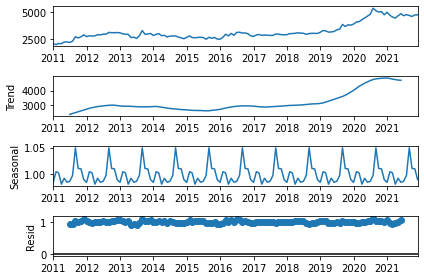

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data=seasonal_decompose(df_new,model="muliplicative")
fig=decompose_data.plot()

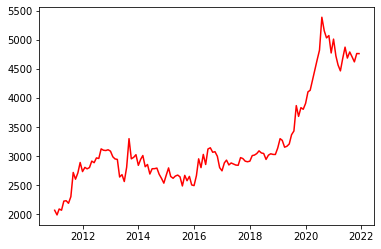

In [ ]:
# PLot Graphs - For Daywise for first 500 Days.

#plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(df_new,color='Red',linestyle='solid')

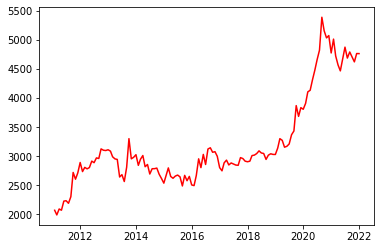

In [ ]:
# PLot Graphs - For Monthwise for first 500 Days.

plt.plot(df_new.Price.resample('M').mean(),color='Red',linestyle='solid')

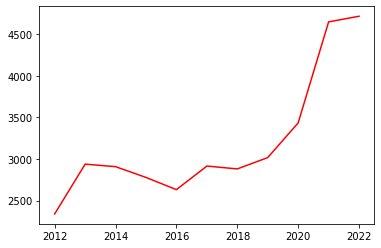

In [ ]:
# PLot Graphs - For Yearwise for first 500 Days.
plt.plot(df_new.Price.resample('Y').mean(),color='Red',linestyle='solid')

## Converting Non-Stationary time-series data into Stationary Time Series 

## 1) Calculate Rolling Statistics For window=12

In [ ]:

def test_stationarity(timeseries):
    
    # Determining rolling statistics
    movingmean=timeseries.rolling(window=12).mean()
    movingSTD=timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig=plt.plot(timeseries,color='blue',label='Original',linestyle='dashed')
    mean=plt.plot(movingmean,color='red',label='RollingMean',linestyle='dotted')
    std=plt.plot(movingSTD,color='black',label='RollingStd',linestyle='solid')
    plt.legend(loc='upper left')
    plt.title("Rolling mean and SD")
    plt.xlabel('Years')
    plt.ylabel('Gold Price')
    
    
    # Perform Dickey-Fuller Test
    print("Result of Dickey-Fuller Test")
    dftest=adfuller(timeseries,autolag='AIC')
    print(dftest)
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistics','P-value','Lags used','No of observation used'])
    print("\n",dfoutput)
    for key,value in dftest[4].items():
        dfoutput['Critical value(%s)'%key]=value
        #dfoutput("\t",key,": ",val)

    print(dfoutput)

Result of Dickey-Fuller Test
(-0.4810857940986786, 0.8956549274286033, 1, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 1517.3183733900958)

 Test Statistics            -0.481086
P-value                     0.895655
Lags used                   1.000000
No of observation used    130.000000
dtype: float64
Test Statistics            -0.481086
P-value                     0.895655
Lags used                   1.000000
No of observation used    130.000000
Critical value(1%)         -3.481682
Critical value(5%)         -2.884042
Critical value(10%)        -2.578770
dtype: float64


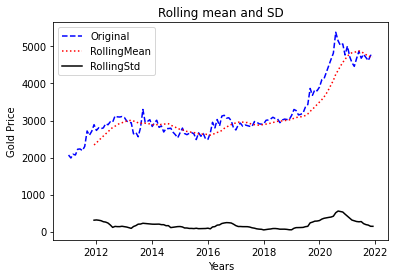

In [ ]:
stationality_check=test_stationarity(df_new.Price)

## 2) Apply Log Transformation and then apply moving average for windows=12

In [ ]:
#dataset_log=np.log(df.Price.resample('M',axis=0).mean())
dataset_log=np.log(df_new.Price)
dataset_log

Dates
2011-01-01    7.633854
2011-02-01    7.594381
2011-03-01    7.644441
2011-04-01    7.634337
2011-05-01    7.707063
                ...   
2021-08-01    8.473868
2021-09-01    8.456168
2021-10-01    8.437717
2021-11-01    8.468213
2021-12-01    8.468003
Freq: MS, Name: Price, Length: 132, dtype: float64

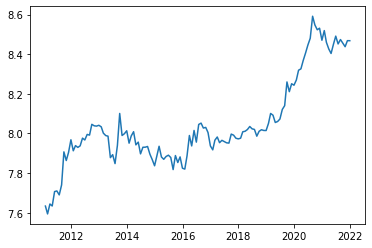

In [ ]:
plt.plot(dataset_log.resample('M').mean())

In [ ]:
#dataset_log=dataset_log.resample('M').mean()
movingavg_log=dataset_log.rolling(window=12).mean()
movingstd_log=dataset_log.rolling(window=12).std()
movingavg_log.head(20)

Dates
2011-01-01         NaN
2011-02-01         NaN
2011-03-01         NaN
2011-04-01         NaN
2011-05-01         NaN
2011-06-01         NaN
2011-07-01         NaN
2011-08-01         NaN
2011-09-01         NaN
2011-10-01         NaN
2011-11-01         NaN
2011-12-01    7.749932
2012-01-01    7.773177
2012-02-01    7.801879
2012-03-01    7.825663
2012-04-01    7.850946
2012-05-01    7.873407
2012-06-01    7.894829
2012-07-01    7.920248
2012-08-01    7.941187
Freq: MS, Name: Price, dtype: float64

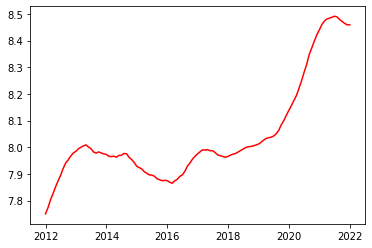

In [ ]:
plt.plot(movingavg_log.dropna().resample('M').mean(),c='red')

In [ ]:
new_dataset_log=dataset_log-movingavg_log
new_dataset_log.dropna(inplace=True)
new_dataset_log.head(10)

Dates
2011-12-01    0.218387
2012-01-01    0.139612
2012-02-01    0.136923
2012-03-01    0.104184
2012-04-01    0.086786
2012-05-01    0.103189
2012-06-01    0.072451
2012-07-01    0.075059
2012-08-01    0.050744
2012-09-01    0.093464
Freq: MS, Name: Price, dtype: float64

Result of Dickey-Fuller Test
(-3.918758349210181, 0.0019010520864856458, 0, 120, {'1%': -3.486055829282407, '5%': -2.8859430324074076, '10%': -2.5797850694444446}, -373.5726420712436)

 Test Statistics            -3.918758
P-value                     0.001901
Lags used                   0.000000
No of observation used    120.000000
dtype: float64
Test Statistics            -3.918758
P-value                     0.001901
Lags used                   0.000000
No of observation used    120.000000
Critical value(1%)         -3.486056
Critical value(5%)         -2.885943
Critical value(10%)        -2.579785
dtype: float64


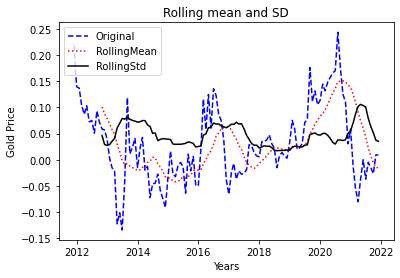

In [ ]:
stationality_check=test_stationarity(new_dataset_log)

## 3) Apply Exponential Moving Average

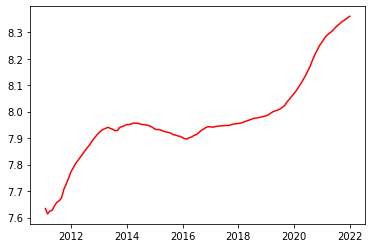

In [ ]:
diffmovavg=dataset_log.ewm(halflife=12,min_periods=0,adjust=True).mean()
plt.plot(diffmovavg.resample('M').mean(),c='red')

Result of Dickey-Fuller Test
(-2.2136369641446323, 0.20133330740189653, 1, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, -416.15682289718325)

 Test Statistics            -2.213637
P-value                     0.201333
Lags used                   1.000000
No of observation used    130.000000
dtype: float64
Test Statistics            -2.213637
P-value                     0.201333
Lags used                   1.000000
No of observation used    130.000000
Critical value(1%)         -3.481682
Critical value(5%)         -2.884042
Critical value(10%)        -2.578770
dtype: float64


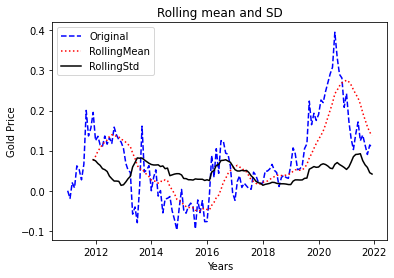

In [ ]:
new_dataset_movavg=dataset_log-diffmovavg
test_stationarity(new_dataset_movavg)

## 4) Differencing Previous value

In [ ]:
 # LogShiftDiff= dataset_log-dataset_log.shift()
# plt.plot(diffprev)

In [ ]:
# LogShiftDiff.dropna(inplace=True)
# test_stationarity(LogShiftDiff)

## Plotting PACF and ACF plots.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


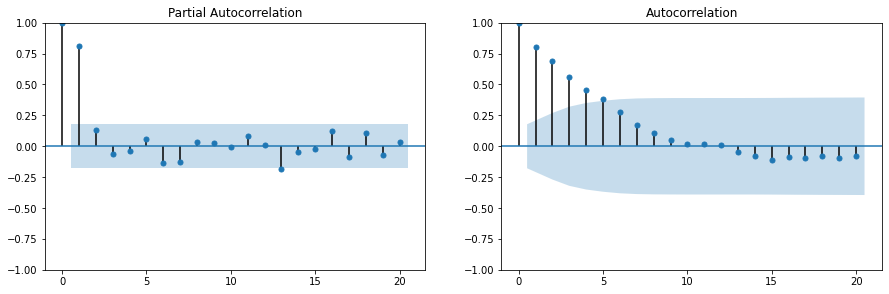

In [ ]:
#Find the lags for AR and MA Models

fig=plt.figure(figsize=(15,10))
ax1=fig.add_subplot(2,2,1)
fig=plot_pacf(new_dataset_log,lags=20,ax=ax1)
ax2=fig.add_subplot(2,2,2)
fig=plot_acf(new_dataset_log,lags=20,ax=ax2)

In [ ]:
# Use ARIMA model only if there is no seasonality in time series model.

# AR - p - Past Lags.
# d- differencing
# MA - q - Past Error

In [ ]:
model=ARIMA(df_new['Price'],order=(5,2,5))
model_fit=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
forecast=model_fit.forecast(steps=12)[0]
forecast

4805.073334044285

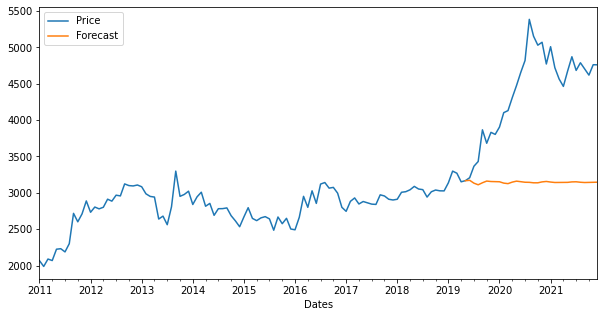

In [ ]:
df_new[['Price','Forecast']].plot(figsize=(10,5))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


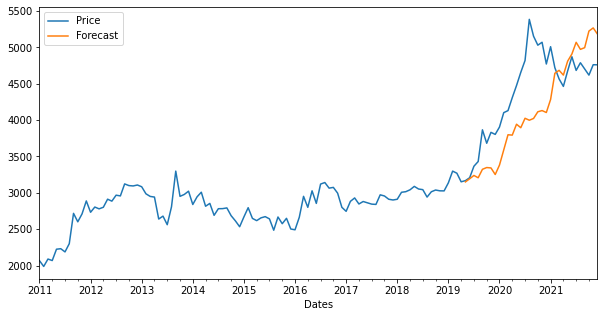

In [ ]:
model_sarimax=sm.tsa.statespace.SARIMAX(df_new['Price'],order=(2,2,1),seasonal_order=(2,2,1,24))
model_sarimax_fit=model_sarimax.fit()

df_new['Forecast']=model_sarimax_fit.predict(start=100,end=131 ,dynamic=True)
df_new[['Price','Forecast']].plot(figsize=(10,5))


In [ ]:
df_new.drop(columns='Forecast',inplace=True)
df_new

,Price
Dates,
2011-01-01,2067
2011-02-01,1987
2011-03-01,2089
2011-04-01,2068
2011-05-01,2224
...,...
2021-08-01,4788
2021-09-01,4704
2021-10-01,4618


In [ ]:
stepwise_fit = auto_arima(df_new['Price'],trace=True, 
                          suppress_warnings=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1685.097, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1686.092, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1683.701, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1684.113, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1686.575, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1685.612, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1685.658, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1687.362, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1685.251, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.323 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -838.850
Date:                Tue, 05 Apr 2022   AIC                           1683.701
Time:                        06:17:26   BIC                           1692.327
Sample:                             0   HQIC                          1687.206
                                - 132                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     24.7022     15.129      1.633      0.103      -4.951      54.355
ar.L1         -0.1813      0.082     -2.200      0.028      -0.343      -0.020
sigma2      2.133e+04   2077.154     10.270      0.000    1.73e+04    2.54e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                45.68
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.90
Prob(H) (two-sided):                  0.36   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
print(df_new.shape)
train=df_new.iloc[:-30]
test=df_new.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(132, 3)
(102, 3) (30, 3)
Price     3365.000000
CMA30     2829.883495
EWMA30    3054.626830
Name: 2019-07-01 00:00:00, dtype: float64 Price     4760.000000
CMA30     3200.825758
EWMA30    4424.734241
Name: 2021-12-01 00:00:00, dtype: float64


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['Price'],order=(5,1,5))
model=model.fit()
model.summary()


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  102
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -626.553
Date:                Tue, 05 Apr 2022   AIC                           1275.106
Time:                        06:17:35   BIC                           1303.872
Sample:                    01-01-2011   HQIC                          1286.751
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0172      0.904      0.019      0.985      -1.755       1.789
ar.L2         -0.3690      0.456     -0.809      0.419      -1.263       0.525
ar.L3         -0.1758      0.521     -0.337      0.736      -1.197       0.846
ar.L4         -0.8007      0.312     -2.570      0.010      -1.411      -0.190
ar.L5          0.4247      0.773      0.550      0.583      -1.090       1.939
ma.L1         -0.1489     10.407     -0.014      0.989     -20.546      20.248
ma.L2          0.2519     10.508      0.024      0.981     -20.343      20.847
ma.L3          0.1684     15.637      0.011      0.991     -30.479      30.815
ma.L4          0.7322      8.984      0.082      0.935     -16.875      18.340
ma.L5         -0.5406     10.860     -0.050      0.960     -21.825      20.744
sigma2      1.447e+04   2.84e+05      0.051      0.959   -5.42e+05    5.71e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.76   Jarque-Bera (JB):                35.64
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.18e+14. Standard errors may be unstable.
"""

In [ ]:
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
#index_future_dates=pd.date_range(start='2018-12-01',end='2018-12-30')


start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA')
#pred.index=index_future_dates

In [ ]:
len(train)

102

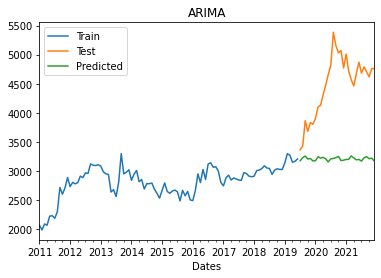

In [ ]:
train['Price'].plot(legend=True,label="Train")
test['Price'].plot(legend=True,label='Test')
pred.plot(legend=True,label='Predicted')
plt.title('ARIMA')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse_arima=(mean_squared_error(pred,test['Price']))
rmse_arima=sqrt(mean_squared_error(pred,test['Price']))
rmse_arima

1370.6028691383033

In [ ]:
model_sarimax=sm.tsa.statespace.SARIMAX(train['Price'],order=(1,2,1),seasonal_order=(1,2,1,12))
model_sarimax_fit=model_sarimax.fit()

In [ ]:
train.shape

(102, 3)

In [ ]:
start=len(train)
end=len(train)+len(test)-1
forecast=model_sarimax_fit.predict(start=start,end=end,dynamic=True)


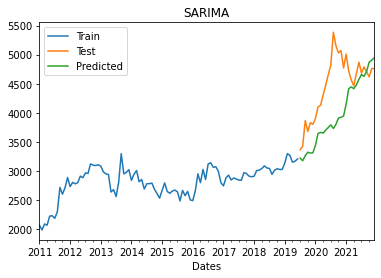

In [ ]:
train['Price'].plot(legend=True,label='Train')
test['Price'].plot(legend=True,label='Test')
forecast.plot(legend=True,label="Predicted")
plt.title('SARIMA')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
sarima_mse=(mean_squared_error(forecast,test['Price']))
sarima_rmse=sqrt(mean_squared_error(forecast,test['Price']))


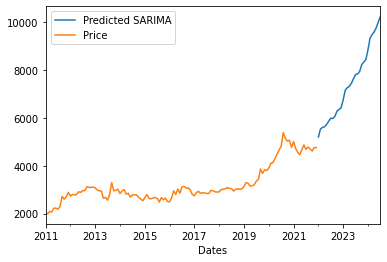

In [ ]:
index_future_dates=pd.date_range(start='2021-12-02',end='2022-02-01')
pred=model_sarimax_fit.predict(start=len(df_new),end=len(df_new)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
#pred.index=index_future_dates
pred.plot(legend=True,label="Predicted SARIMA")
df_new['Price'].plot(legend=True)

In [ ]:
df_new.tail()

,Price,Forecast
Dates,,
2021-08-01,4788,3144.841614
2021-09-01,4704,3141.189583
2021-10-01,4618,3143.184327
2021-11-01,4761,3144.754962
2021-12-01,4760,3145.795646


In [ ]:
test['Price'].mean()

In [ ]:
df_new.tail()


In [ ]:
plt.figure(figsize=(20,4))

plt.subplot(1, 2, 1)

plt.plot(pred)
plt.plot(test['Price'])
plt.title('ARIMA')

plt.subplot(1, 2, 2)

plt.plot(forecast)
plt.plot(test['Price'])
plt.title('SARIMA')

plt.show()

In [ ]:
pred.plot(legend=True,label='SARIMA')
test['Price'].plot(legend=True,label='Price')
plt.title('SARIMA')

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 


In [ ]:
Train = df_new.head(100)
Test = df_new.tail(32)

In [ ]:
Train.shape,Test.shape

((100, 1), (32, 1))

In [ ]:
Test.index

In [ ]:
df_new.shape

(132, 1)

In [ ]:
def RMSE(org, pred):
    rmse=np.sqrt(np.mean((np.array(org)-np.array(pred))**2))
    return round(rmse)

In [ ]:
def MSE(org, pred):
    mse=(np.mean((np.array(org)-np.array(pred))**2))
    return round(mse)

In [ ]:
ses_model = SimpleExpSmoothing(Train["Price"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
ses_model_MSE = MSE(Test.Price, pred_ses)
ses_model_RMSE = RMSE(Test.Price, pred_ses)
print(ses_model_MSE)

1836692


In [ ]:
hw_model = Holt(Train["Price"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
hw_model_RMSE = RMSE(Test.Price, pred_hw)
hw_model_MSE = MSE(Test.Price, pred_hw)
hw_model_MSE

1170927

In [ ]:
hwe_model_add_add = ExponentialSmoothing(Train["Price"],seasonal="add",trend="add",seasonal_periods=36).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
hwe_add_add_model_RMSE = RMSE(Test.Price, pred_hwe_add_add)
hwe_add_add_model_MSE = MSE(Test.Price, pred_hwe_add_add)


In [ ]:
hwe_model_mul_add = ExponentialSmoothing(Train["Price"],seasonal="mul",trend="mul",seasonal_periods=48).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
hwe_model_mul_add_model_RMSE = RMSE(Test.Price, pred_hwe_mul_add)
hwe_model_mul_add_model_MSE = MSE(Test.Price, pred_hwe_mul_add)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


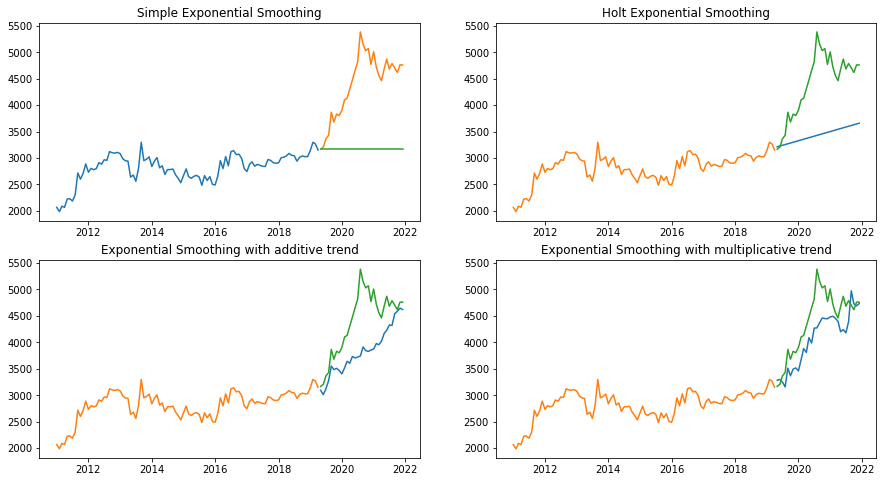

In [ ]:
plt.figure(figsize=(15,8))

plt.subplot(2, 2, 1)


plt.plot(Train["Price"],label=Train)
plt.plot(Test["Price"],label=Test)
plt.plot(pred_ses,label='Predicted')
plt.plot(legend=True)
plt.title('Simple Exponential Smoothing')


plt.subplot(2, 2, 2)

plt.plot(pred_hw)
plt.plot(Train["Price"])
plt.plot(Test["Price"])
plt.title('Holt Exponential Smoothing')

plt.subplot(2, 2, 3)

plt.plot(pred_hwe_add_add)
plt.plot(Train["Price"])
plt.plot(Test["Price"])
plt.title('Exponential Smoothing with additive trend')

plt.subplot(2, 2, 4)

plt.plot(pred_hwe_mul_add)
plt.plot(Train["Price"])
plt.plot(Test["Price"])
plt.title('Exponential Smoothing with multiplicative trend')

plt.show()

In [ ]:
df_new.tail()

,Price,CMA30,EWMA30
Dates,,,
2021-08-01,4788,3153.640625,4336.466465
2021-09-01,4704,3165.658915,4360.182659
2021-10-01,4618,3176.830769,4376.818892
2021-11-01,4761,3188.923664,4401.608751
2021-12-01,4760,3200.825758,4424.734241


In [ ]:

# Simple Moving Average
df_new1 = df_new.copy()
df_new1['SMA30'] = df_new1['Price'].rolling(12).mean()
df_new1.dropna(inplace=True)



# Cumulative Moving Average
df_new['CMA30'] = df_new['Price'].expanding().mean()
# Exponential Moving Average
df_new['EWMA30'] = df_new['Price'].ewm(span=30).mean()






In [ ]:
mse_model_SMA = MSE(df_new1['Price'], df_new1['SMA30'])
rmse_model_SMA = RMSE(df_new1['Price'], df_new1['SMA30'])

mse_model_CMA = MSE(df_new['Price'], df_new['CMA30'])
rmse_model_CMA = RMSE(df_new['Price'], df_new['CMA30'])

mse_model_EMA = MSE(df_new['Price'], df_new['EWMA30'])
rmse_model_EMA = RMSE(df_new['Price'], df_new['EWMA30'])


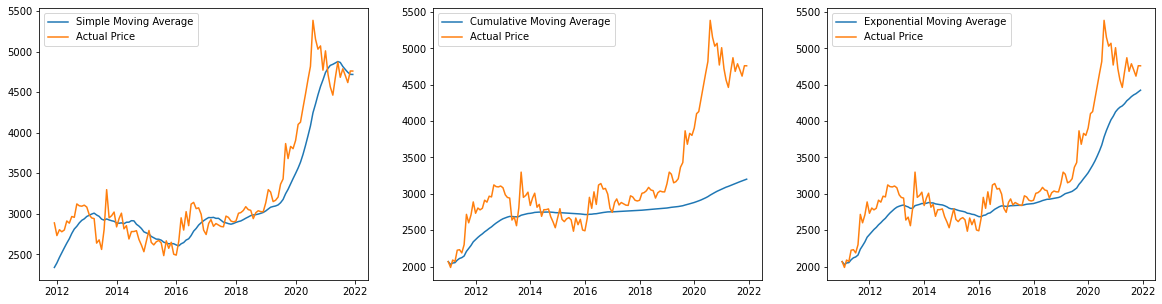

In [ ]:

# Simple Moving Average
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.plot(df_new1['SMA30'],label='Simple Moving Average')
plt.plot(df_new1['Price'],label='Actual Price')
plt.legend(loc="upper left")

plt.subplot(1, 3, 2)
plt.plot(df_new['CMA30'],label='Cumulative Moving Average')
plt.plot(df_new['Price'],label='Actual Price')
plt.legend(loc="upper left")

plt.subplot(1, 3, 3)
plt.plot(df_new['EWMA30'],label='Exponential Moving Average')
plt.plot(df_new['Price'],label='Actual Price')
plt.legend(loc="upper left")

plt.show()

In [ ]:
(mse_model_SMA)
ses_model_MSE


In [ ]:
dict= {'RMSE':[rmse_model_SMA,rmse_model_CMA,sarima_rmse,ses_model_RMSE,hw_model_RMSE,hwe_add_add_model_RMSE,hwe_model_mul_add_model_RMSE,rmse_arima,rmse_model_EMA],  
      'MSE':[round(mse_model_SMA),mse_model_CMA,mse_model_EMA,ses_model_MSE,hw_model_MSE,hwe_add_add_model_MSE,hwe_model_mul_add_model_MSE,mse_arima,sarima_mse]}
 
df_allvalues=pd.DataFrame(dict,index=['Simple_MA','Cumulative_MA','Exponential_MA',
                                      'SimpleExponSmothening','HoltExponSmothening','Smoothing with add trend','Smoothing with Mul trend',
                                      'ARIMA','SARIMA'])    
df_allvalues



,RMSE,MSE
Simple_MA,275.000000,7.575200e+04
Cumulative_MA,769.000000,5.911060e+05
Exponential_MA,672.631431,1.586770e+05
SimpleExponSmothening,1355.000000,1.836692e+06
HoltExponSmothening,1082.000000,1.170927e+06
Smoothing with add trend,706.000000,4.991380e+05
Smoothing with Mul trend,442.000000,1.953760e+05
ARIMA,1370.602869,1.878552e+06
SARIMA,398.000000,4.524330e+05
